In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import product

# Load and Scale Datasets

In [2]:
#load dataset
df = pd.read_csv('weather_data.csv')
cols_to_scale = [col for col in df.columns if col not in ['Month', 'Month_Num', 'Location']]

In [3]:
#scale data
df[cols_to_scale] = StandardScaler().fit_transform(df[cols_to_scale])

# PCA

In [4]:
#run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df[cols_to_scale])
df["PC1"] = principal_components[:,0]
df["PC2"] = principal_components[:,1]

In [5]:
#calculate explained variance
explained_variances = pca.explained_variance_ratio_
total_explained = np.sum(explained_variances)

## Plot PCA Results

Text(0.5, 1.0, 'PCA of Weather Data (Total Explained Variance: 85.1%)')

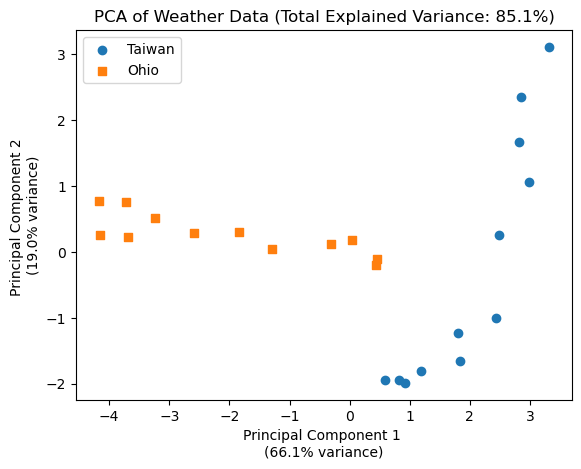

In [6]:
#plot results on scatterplot
plt.scatter(df[df["Location"]=="TW"]["PC1"], df[df["Location"]=="TW"]["PC2"], marker = "o",label='Taiwan')
plt.scatter(df[df["Location"]=="OH"]["PC1"], df[df["Location"]=="OH"]["PC2"], marker = "s", label='Ohio')
plt.legend()
plt.xlabel(f'Principal Component 1 \n({explained_variances[0]*100:.1f}% variance)')
plt.ylabel(f'Principal Component 2 \n({explained_variances[1]*100:.1f}% variance)')
plt.title(f'PCA of Weather Data (Total Explained Variance: {total_explained*100:.1f}%)')

# Neighbor Matching

In [7]:
#make dataframe with all possible month combinations, PC1 and PC2 values for each location
Results = pd.DataFrame(list(product(df["Month_Num"].unique(), repeat = 2)),columns= ["TW_Month","OH_Month"])
Results = Results.merge(df[df["Location"]=="TW"][["Month_Num","PC1","PC2"]],left_on = "TW_Month", right_on = "Month_Num").merge(df[df["Location"]=="OH"][["Month_Num","PC1","PC2"]],left_on = "OH_Month", right_on = "Month_Num",suffixes=("_TW","_OH")).drop(columns=["Month_Num_TW","Month_Num_OH"])

In [8]:
#Compute Euclidean distances between months
Results["Distance"] = np.linalg.norm(Results[["PC1_TW","PC2_TW"]].values - Results[["PC1_OH","PC2_OH"]].values, axis=1)

In [9]:
#find nearest match for each month in Taiwan
Matches = Results.groupby("TW_Month").agg({"Distance":"min"}).merge(Results, left_on= ["TW_Month","Distance"], right_on = ["TW_Month","Distance"])[["TW_Month","OH_Month","Distance"]]

# Other Plots

In [40]:
df_unscaled = pd.read_csv('weather_data.csv')

def c_to_f(c):
    return (c * 9/5) + 32

df_unscaled[["High Temperature","Mean Temperature","Low Temperature"]] = df_unscaled[["High Temperature","Mean Temperature","Low Temperature"]].apply(c_to_f)

TW = df_unscaled[df_unscaled["Location"]=="TW"]
OH = df_unscaled[df_unscaled["Location"]=="OH"]
months = TW["Month"].values
months = [month[:3] for month in months]

Text(0.5, 1.0, 'Monthly Average Temperatures: Tainan vs Cleveland')

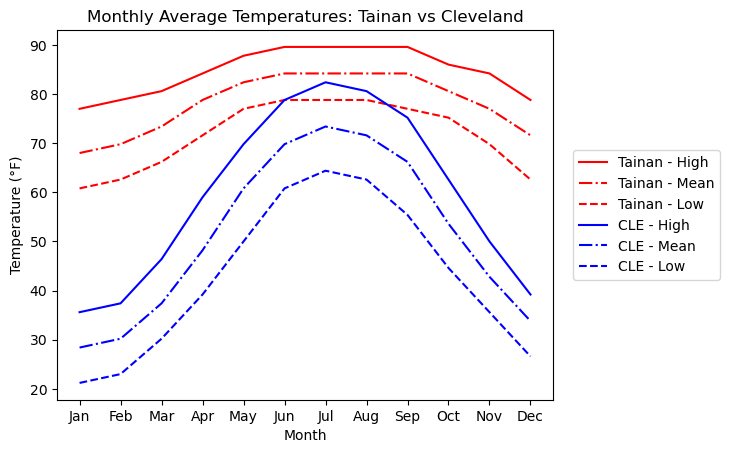

In [42]:
plt.plot(months,TW["High Temperature"], label="Tainan - High", color="red", linestyle='-')
plt.plot(months,TW["Mean Temperature"], label="Tainan - Mean", color="red", linestyle='-.')
plt.plot(months,TW["Low Temperature"], label="Tainan - Low", color="red", linestyle='--')
plt.plot(months,OH["High Temperature"], label="CLE - High", color="blue", linestyle='-')
plt.plot(months,OH["Mean Temperature"], label="CLE - Mean", color="blue", linestyle='-.')
plt.plot(months,OH["Low Temperature"], label="CLE - Low", color="blue", linestyle='--')
plt.legend(loc = "center right",bbox_to_anchor=(1.35, 0.5))
plt.xlabel("Month")
plt.ylabel("Temperature (°F)")
plt.title("Monthly Average Temperatures: Tainan vs Cleveland")

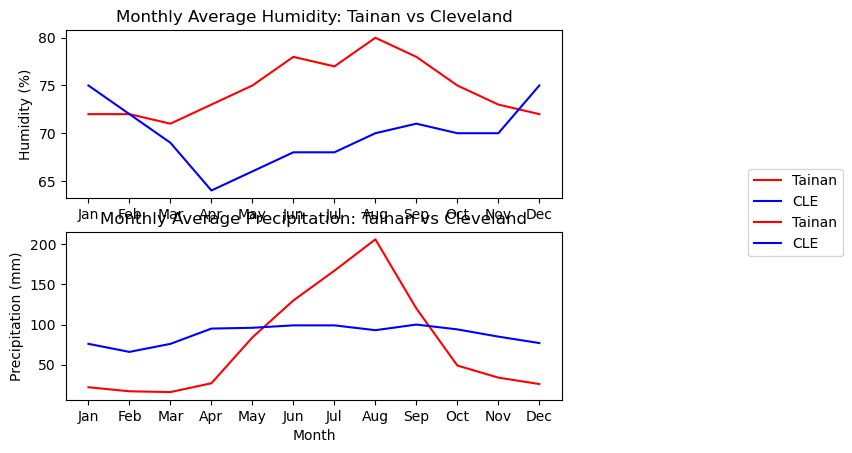

In [47]:
fig, ax = plt.subplots(nrows = 2, ncols = 1)
ax[0].plot(months,TW["Humidity"], label="Tainan", color="red")
ax[0].plot(months,OH["Humidity"], label="CLE", color="blue")
ax[1].plot(months,TW["Precipitation"], label="Tainan", color="red")
ax[1].plot(months,OH["Precipitation"], label="CLE", color="blue")
ax[0].set_ylabel("Humidity (%)")
ax[1].set_ylabel("Precipitation (mm)")
ax[1].set_xlabel("Month")
ax[0].set_title("Monthly Average Humidity: Tainan vs Cleveland")
ax[1].set_title("Monthly Average Precipitation: Tainan vs Cleveland")
fig.legend(loc = "center right",bbox_to_anchor=(1.35, 0.5))